# Importing libraries

In [ ]:
# !pip install quandl
# !pip install --upgrade --no-deps statsmodels
# !pip install pycaret
# !pip install kats
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U sklearn
# !pip install ta 
# !pip install -U pmdarima


In [79]:
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import random
import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import *
from kats.consts import TimeSeriesData
from pmdarima import auto_arima

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
quandl.ApiConfig.api_key = "2At3atzXCrMx_BXfkyz7"

# Data to be used 

In [10]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [11]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [12]:
# Test Data Start and end date
start_date = '2020-03-02'
end_date = '2021-03-23'

In [13]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = allSymbols):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [14]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
    print(result)
    out = pd.Series(result[0:4], index=label)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    print(out.to_string())
    if(result[1]<0.05):
        return ('Data is stationary')
    else:
        return 'Data is non-stationary'

# Time Series DataSet

In [15]:
dataset = pd.read_csv('TimeSeriesData.csv')
dataset.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
0,2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
1,2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2,2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
3,2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
4,2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105449 entries, 0 to 105448
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       105449 non-null  object 
 1   Open                       95130 non-null   float64
 2   High                       95130 non-null   float64
 3   Low                        95130 non-null   float64
 4   Close                      105449 non-null  float64
 5   WAP                        74255 non-null   float64
 6   No. of Shares              74255 non-null   float64
 7   No. of Trades              74255 non-null   float64
 8   Total Turnover             74255 non-null   float64
 9   Deliverable Quantity       68110 non-null   float64
 10  % Deli. Qty to Traded Qty  68110 non-null   float64
 11  Spread H-L                 74255 non-null   float64
 12  Spread C-O                 74255 non-null   float64
 13  StockName                  10

In [ ]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges

In [18]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges.code==stockCode, 'StockName'].values[0];

In [ ]:
data = dataset.set_index('Date')
data.head()

# Populate dictionary to hold individual Stock Data

In [20]:
# ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]



In [36]:
len(allSymbols)

21

# View null values in the data

In [ ]:
getNullValuesForSetOfStocks()

# Deriving Technical indicators

### MACD

In [53]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [54]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

### RSI - Relative Strength Index

In [51]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [52]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

## ATR

In [41]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [42]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

## Bollinger band

In [43]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [44]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

## OBV

In [45]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [46]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

## ADX

In [55]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [56]:
# ADX
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

# Removing Extra Columms

In [ ]:
allSymbols

In [57]:
OriginalScriptWiseData = ScriptWiseData
for symbol in allSymbols:
    ScriptWiseData[symbol] = ScriptWiseData[symbol][['Close']+TechnicalIndicators]

In [80]:
# for symbol in allSymbols:
#     print(ScriptWiseData[symbol])
ScriptWiseData['BOM524715']

,Close,RSI,ATR,MACD,adx,OBV
Date,,,,,,
2002-04-03,689.60,1.855032,18.5275,8.463682,22.503432,3522925.0
2002-04-04,682.90,1.578704,19.2250,8.745214,21.443984,3520801.0
2002-04-05,683.50,1.592997,19.3250,8.905707,20.460211,3525521.0
2002-04-08,680.85,1.492080,18.2750,8.736332,19.615533,3524649.0
2002-04-09,672.00,1.216358,18.5025,7.859934,18.610020,3524226.0
...,...,...,...,...,...,...
2021-03-17,585.20,0.682121,17.9600,-1.488529,16.856154,7598758.0
2021-03-18,574.50,0.594893,18.3000,-3.999505,18.296442,7374060.0
2021-03-19,578.60,0.647393,18.6500,-5.594151,20.001070,7557363.0


## Dropping null values

In [62]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
#     ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna()    

# ARIMAX for Stock "BOM524715"

In [140]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from math import sqrt
from scipy.stats.distributions import chi2

In [ ]:
Stock = 'BOM524715'
ScriptWiseData[Stock].Close

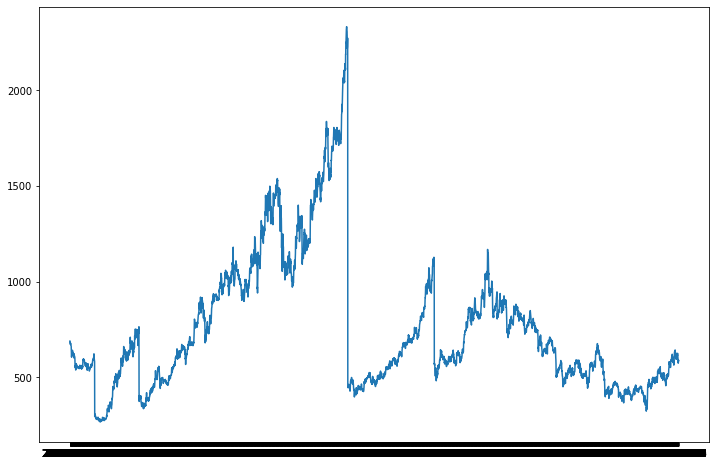

In [135]:
plt.figure(figsize=[12,8])
plt.plot(ScriptWiseData[Stock].Close)
plt.show()

In [176]:
print(adf_test(ScriptWiseData[Stock].Close, title='ADF Test for Stock market prices'))

(-3.19554714784556, 0.020243878935258808, 0, 4707, {'1%': -3.4317400296926333, '5%': -2.862154234399525, '10%': -2.5670969591609873}, 45966.78071524844)
ADF test statistic        -3.195547
p-value                    0.020244
# lags used                0.000000
#observations           4707.000000
critical value (1%)       -3.431740
critical value (5%)       -2.862154
critical value (10%)      -2.567097
Data is stationary



### The ACF





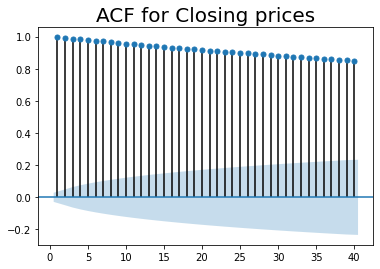

In [76]:
sgt.plot_acf(ScriptWiseData[Stock].Close, zero= False, lags = 40);
plt.title("ACF for Closing prices", size = 20)
plt.show()

### The PACF



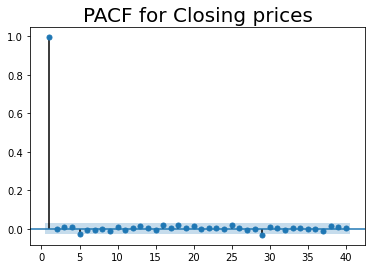

In [77]:
sgt.plot_pacf(ScriptWiseData[Stock].Close, alpha= 0.05, zero= False, lags = 40, method=('ols'));
plt.title("PACF for Closing prices", size = 20)
plt.show()

### Common functions

In [185]:
test_start_date = '2020-03-02'
test_end_date = '2021-03-23'
actual = ScriptWiseData[Stock].Close.loc[test_start_date:test_end_date]
len(actual)

265

In [132]:
def calculateRMSE(pred,actual = actual):
  print("RMSE : " + str(sqrt(mean_squared_error(actual, pred))))

In [157]:
def LLRTest(mod_1, mod_2, DF=1):
  L1 = mod_1.fit().llf
  L2 = mod_2.fit().llf
  LR = (2*(L2-L1))
  P = chi2.sf(LR, DF).round(3)
  return P


In [207]:
def plot_acf(data, title = ''):
  sgt.plot_acf(data, lags = 40, zero = False)
  plt.title(title, size=24)
  plt.show()

def plot_pacf(data, title = ''):
  sgt.plot_pacf(data, lags = 40, zero = False, method= ('ols'))
  plt.title(title, size=24)
  plt.show()

In [271]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

### The AR(1) model



In [272]:
train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[Stock].Close)


In [278]:
model_ar = ARMA(ScriptWiseData[Stock].Close, order = (1,0))
result_ar = model_ar.fit()
df_pred = result_ar.predict(start = test_start_date, end = test_end_date)



KeyError: ignored

In [ ]:
result_ar.summary()
print(df_pred)

In [ ]:
calculateRMSE(df_pred)

### Higher-Lag AR Models





> With Lag 2



In [ ]:
model_ar_2 = ARMA(ScriptWiseData[Stock].Close, order = (2,0))
result_ar_2 = model_ar_2.fit()
df_pred_2 = result_ar_2.predict(start = test_start_date, end = test_end_date)
result_ar_2.summary()



> With Lag 8



In [179]:
model_ar_8 = ARMA(ScriptWiseData[Stock].Close, order = (8,0))
result_ar_8 = model_ar_8.fit()
df_pred_8 = result_ar_8.predict(start = test_start_date, end = test_end_date)

In [180]:
calculateRMSE(df_pred_8)

RMSE : 11.144881384437978




> With Lag 20



In [182]:
model_ar_20 = ARMA(ScriptWiseData[Stock].Close, order = (20,0))
result_ar_20 = model_ar_20.fit()
df_pred_20 = result_ar_20.predict(start = test_start_date, end = test_end_date)

In [184]:
calculateRMSE(df_pred_20)

RMSE : 11.156334794412102


In [172]:
print(LLRTest(model_ar, model_ar_2))
print(LLRTest(model_ar, model_ar_8))
print(LLRTest(model_ar, model_ar_20))

0.967
0.001


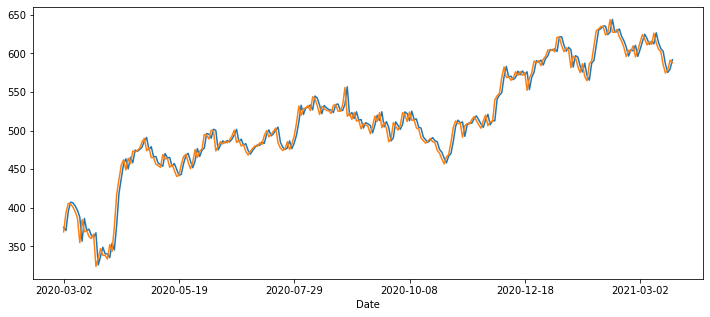

In [270]:
df_pred.plot(figsize = (12,5))
actual.plot(figsize = (12,5))

# Using Returns

In [198]:
Stock_Returns = ScriptWiseData[Stock].Close.pct_change(1).mul(100)
Stock_Returns = Stock_Return.iloc[1:]  
Stock_Returns



> ADF Test on returns



In [202]:
print(adf_test(Stock_Returns, title='ADF Test for Stock market Returns'))

(-69.02918352751362, 0.0, 0, 4706, {'1%': -3.4317403252279095, '5%': -2.8621543649618517, '10%': -2.5670970286650188}, 22316.521758307892)
ADF test statistic       -69.029184
p-value                    0.000000
# lags used                0.000000
#observations           4706.000000
critical value (1%)       -3.431740
critical value (5%)       -2.862154
critical value (10%)      -2.567097
Data is stationary


### ACF and PACF for Returns

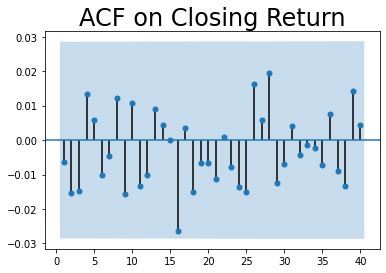

In [208]:
plot_acf(Stock_Returns, 'ACF on Closing Return')

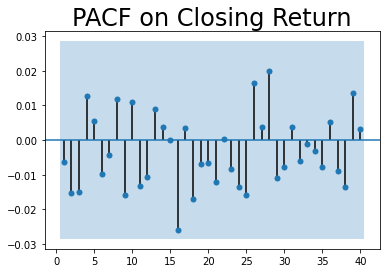

In [209]:
plot_pacf(Stock_Returns, 'PACF on Closing Return')

### AR(1) model for returns

In [220]:
Stock_Returns.describe()

count    4707.000000
mean        0.045482
std         2.628061
min       -79.919900
25%        -0.998455
50%         0.025281
75%         1.114753
max        10.960362
Name: Close, dtype: float64

In [ ]:
# Actual Returns 
test_start_date = '2020-03-02'
test_end_date = '2021-03-23'
actual_returns = Stock_Returns.loc[test_start_date:test_end_date]
print(actual_returns)

In [216]:
model_ret_ar_1 = ARMA(Stock_Returns, order = (1,0))
result_ret_ar_1 = model_ret_ar_1.fit()
df_pred_ret_1 = result_ret_ar_1.predict(start = test_start_date, end = test_end_date)


In [219]:
result_ret_ar_1.summary()
#print(df_pred_ret_1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4707
Model:                     ARMA(1, 0)   Log Likelihood              -11226.468
Method:                       css-mle   S.D. of innovations              2.628
Date:                Wed, 14 Jul 2021   AIC                          22458.936
Time:                        13:03:58   BIC                          22478.306
Sample:                             0   HQIC                         22465.745
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0455      0.038      1.195      0.232      -0.029       0.120
ar.L1.Close    -0.0064      0.015     -0.441      0.659      -0.035       0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -155.4527           +0.0000j          155.4527            0.5000
-----------------------------------------------------------------------------
"""

In [215]:
calculateRMSE(df_pred_returns_1,actual_returns)

RMSE : 2.41303633709757


### Higher-Lag AR Models for Returns





> With Lag 2



In [222]:

model_ret_ar_2 = ARMA(Stock_Returns, order = (2,0))
result_ret_ar_2 = model_ret_ar_2.fit()
df_pred_ret_2 = result_ret_ar_2.predict(start = test_start_date, end = test_end_date)
result_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4707
Model:                     ARMA(2, 0)   Log Likelihood              -11225.909
Method:                       css-mle   S.D. of innovations              2.627
Date:                Wed, 14 Jul 2021   AIC                          22459.818
Time:                        13:08:29   BIC                          22485.645
Sample:                             0   HQIC                         22468.898
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0455      0.037      1.214      0.225      -0.028       0.119
ar.L1.Close    -0.0065      0.015     -0.448      0.654      -0.035       0.022
ar.L2.Close    -0.0154      0.015     -1.057      0.290      -0.044       0.013
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2120           -8.0535j            8.0563           -0.2542
AR.2           -0.2120           +8.0535j            8.0563            0.2542
-----------------------------------------------------------------------------
"""



> With Lag 8



In [224]:

model_ret_ar_8 = ARMA(Stock_Returns, order = (8,0))
result_ret_ar_8 = model_ret_ar_8.fit()
df_pred_ret_8 = result_ret_ar_8.predict(start = test_start_date, end = test_end_date)
result_ret_ar_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4707
Model:                     ARMA(8, 0)   Log Likelihood              -11224.306
Method:                       css-mle   S.D. of innovations              2.627
Date:                Wed, 14 Jul 2021   AIC                          22468.613
Time:                        13:12:37   BIC                          22533.181
Sample:                             0   HQIC                         22491.312
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0455      0.038      1.212      0.226      -0.028       0.119
ar.L1.Close    -0.0066      0.015     -0.451      0.652      -0.035       0.022
ar.L2.Close    -0.0150      0.015     -1.026      0.305      -0.044       0.014
ar.L3.Close    -0.0150      0.015     -1.032      0.302      -0.044       0.014
ar.L4.Close     0.0125      0.015      0.856      0.392      -0.016       0.041
ar.L5.Close     0.0057      0.015      0.391      0.696      -0.023       0.034
ar.L6.Close    -0.0097      0.015     -0.668      0.504      -0.038       0.019
ar.L7.Close    -0.0041      0.015     -0.281      0.778      -0.033       0.024
ar.L8.Close     0.0120      0.015      0.821      0.412      -0.017       0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7396           -0.0000j            1.7396           -0.5000
AR.2           -1.2530           -1.1921j            1.7295           -0.3790
AR.3           -1.2530           +1.1921j            1.7295            0.3790
AR.4            0.0623           -1.6472j            1.6484           -0.2440
AR.5            0.0623           +1.6472j            1.6484            0.2440
AR.6            1.3127           -1.2220j            1.7935           -0.1193
AR.7            1.3127           +1.2220j            1.7935            0.1193
AR.8            1.8383           -0.0000j            1.8383           -0.0000
-----------------------------------------------------------------------------
"""

In [225]:
calculateRMSE(df_pred_ret_8, actual_returns)


RMSE : 2.413261383454531




> With Lag 20



In [227]:
model_ret_ar_20 = ARMA(Stock_Returns, order = (20,0))
result_ret_ar_20 = model_ret_ar_20.fit()
df_pred_ret_20 = result_ret_ar_20.predict(start = test_start_date, end = test_end_date)
result_ret_ar_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4707
Model:                    ARMA(20, 0)   Log Likelihood              -11220.020
Method:                       css-mle   S.D. of innovations              2.624
Date:                Wed, 14 Jul 2021   AIC                          22484.040
Time:                        13:21:48   BIC                          22626.090
Sample:                             0   HQIC                         22533.979
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0456      0.035      1.302      0.193      -0.023       0.114
ar.L1.Close     -0.0062      0.015     -0.423      0.672      -0.035       0.022
ar.L2.Close     -0.0155      0.015     -1.065      0.287      -0.044       0.013
ar.L3.Close     -0.0151      0.015     -1.039      0.299      -0.044       0.013
ar.L4.Close      0.0124      0.015      0.853      0.393      -0.016       0.041
ar.L5.Close      0.0055      0.015      0.378      0.706      -0.023       0.034
ar.L6.Close     -0.0099      0.015     -0.681      0.496      -0.038       0.019
ar.L7.Close     -0.0045      0.015     -0.311      0.756      -0.033       0.024
ar.L8.Close      0.0123      0.015      0.846      0.397      -0.016       0.041
ar.L9.Close     -0.0168      0.015     -1.154      0.248      -0.045       0.012
ar.L10.Close     0.0107      0.015      0.731      0.465      -0.018       0.039
ar.L11.Close    -0.0130      0.015     -0.892      0.372      -0.042       0.016
ar.L12.Close    -0.0105      0.015     -0.719      0.472      -0.039       0.018
ar.L13.Close     0.0086      0.015      0.592      0.554      -0.020       0.037
ar.L14.Close     0.0037      0.015      0.253      0.801      -0.025       0.032
ar.L15.Close    -0.0002      0.015     -0.013      0.990      -0.029       0.028
ar.L16.Close    -0.0261      0.015     -1.790      0.073      -0.055       0.002
ar.L17.Close     0.0032      0.015      0.216      0.829      -0.025       0.032
ar.L18.Close    -0.0171      0.015     -1.177      0.239      -0.046       0.011
ar.L19.Close    -0.0070      0.015     -0.480      0.631      -0.036       0.022
ar.L20.Close    -0.0066      0.015     -0.451      0.652      -0.035       0.022
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1670           -0.2122j            1.1862           -0.0286
AR.2             1.1670           +0.2122j            1.1862            0.0286
AR.3             1.0473           -0.5999j            1.2070           -0.0828
AR.4             1.0473           +0.5999j            1.2070            0.0828
AR.5             0.7957           -0.9468j            1.2368           -0.1388
AR.6             0.7957           +0.9468j            1.2368            0.1388
AR.7             0.5383           -1.2297j            1.3423           -0.1843
AR.8             0.5383           +1.2297j            1.3423            0.1843
AR.9             0.1752           -1.2357j            1.2481           -0.2276
AR.10            0.1752           +1.2357j            1.2481            0.2276
AR.11           -0.2952           -1.2005j            1.2362           -0.2884
AR.12           -0.2952           +1.2005j            1.2362            0.2884
AR.13           -1.1799          

In [229]:
calculateRMSE(df_pred_ret_20, actual_returns)

RMSE : 2.3998191685198837


In [228]:
print(LLRTest(model_ret_ar_1, model_ret_ar_2))
print(LLRTest(model_ret_ar_1, model_ret_ar_8))
print(LLRTest(model_ret_ar_1, model_ret_ar_20))

0.29
0.038
0.0


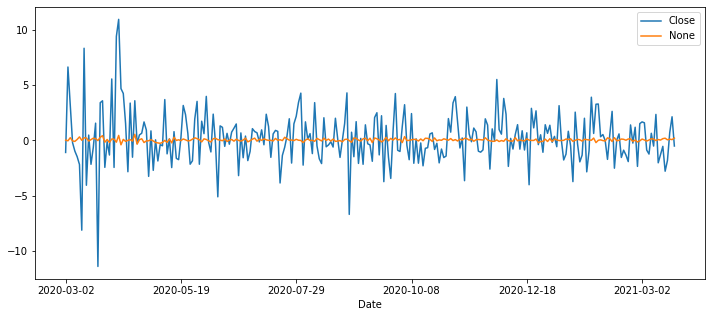

In [266]:
actual_returns.plot(figsize = (12,5), legend = True)
df_pred_ret_20.plot(figsize = (12,5), legend = True)

# Normalizing values and returns

In [ ]:
benchmark_prices = ScriptWiseData[Stock].Close.iloc[0]
Normalized_prices = ScriptWiseData[Stock].Close.div(benchmark_prices).mul(100)

actual_returns_normal = Normalized_prices.loc[test_start_date:test_end_date]
print(benchmark_prices)
print(Normalized_prices)


In [ ]:
ScriptWiseData[Stock].Close.describe()

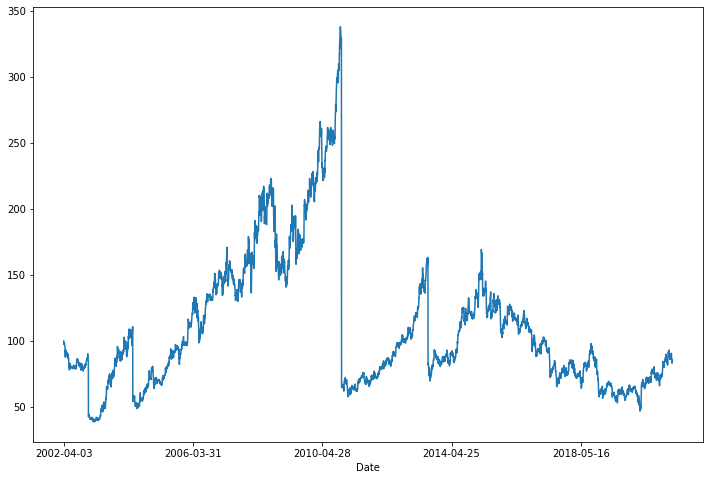

In [259]:
Normalized_prices.plot(figsize = (12,8))

In [ ]:
adf_test(Normalized_prices)

In [254]:
model_ar_normal_1 = ARMA(Normalized_prices, order = (1,0))
result_ar_normal_1 = model_ar_normal_1.fit()
df_pred_normal_1 = result_ar_normal_1.predict(start = test_start_date, end = test_end_date)
print(result_ar_normal_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4708
Model:                     ARMA(1, 0)   Log Likelihood              -14040.542
Method:                       css-mle   S.D. of innovations              4.772
Date:                Wed, 14 Jul 2021   AIC                          28087.085
Time:                        13:44:52   BIC                          28106.456
Sample:                             0   HQIC                         28093.895
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         108.0717     14.635      7.385      0.000      79.389     136.755
ar.L1.Close     0.9955      0.001    747.462      0.000       0.993       0.998
                                    Roots       

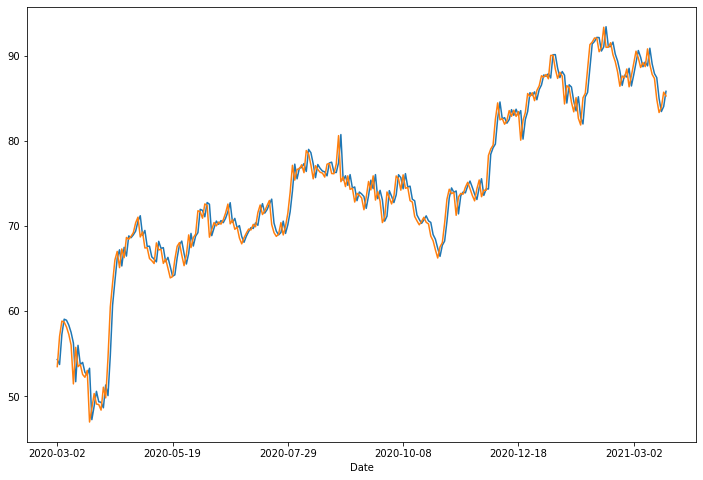

In [263]:
df_pred_normal_1.plot(figsize = (12,8))
actual_returns_normal.plot(figsize = (12,8))



In [255]:

model_ar_normal_8 = ARMA(Normalized_prices, order = (8,0))
result_ar_normal_8 = model_ar_normal_8.fit()
df_pred_normal_8 = result_ar_normal_8.predict(start = test_start_date, end = test_end_date)
print(result_ar_normal_8.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4708
Model:                     ARMA(8, 0)   Log Likelihood              -14038.373
Method:                       css-mle   S.D. of innovations              4.770
Date:                Wed, 14 Jul 2021   AIC                          28096.747
Time:                        13:45:03   BIC                          28161.317
Sample:                             0   HQIC                         28119.447
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         108.1403     14.432      7.493      0.000      79.854     136.427
ar.L1.Close     0.9961      0.015     68.359      0.000       0.968       1.025
ar.L2.Close    -0.0103      0.021     -0.500    

In [256]:
calculateRMSE(df_pred_normal_1,actual_returns_normal)

RMSE : 1.6163551016102118


In [257]:
calculateRMSE(df_pred_normal_8,actual_returns_normal)

RMSE : 1.615962520153878


In [258]:
LLRTest(model_ar_normal_1, model_ar_normal_8)

0.037

### Auto Arima Functionality

In [165]:
stepwise_fit = auto_arima(ScriptWiseData[Stock].Close, start_p=0, start_q=0, max_p=6, max_q = 3, seasonal= False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46263.458, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46265.446, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46265.447, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46261.460, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46267.447, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.311 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4708
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -23129.730
Date:                Wed, 14 Jul 2021   AIC                          46261.460
Time:                        12:03:53   BIC                          46267.917
Sample:                             0   HQIC                         46263.730
                               - 4708                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1085.4085      0.711   1526.979      0.000    1084.015    1086.802
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):         768804220.46
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                           -37.00
Prob(H) (two-sided):                  0.00   Kurtosis:                      1981.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
stepwise_fit_ = auto_arima(ScriptWiseData[Stock].Close, start_p=0, start_q=0, max_p=4, max_q = 4, seasonal= True, trace=True,m=12)
stepwise_fit_.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=46263.922, Time=6.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=46263.458, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=46266.431, Time=1.75 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=46266.393, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46261.460, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=46264.446, Time=1.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=46264.406, Time=1.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=46265.446, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=46265.447, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=46267.447, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 12.531 seconds


(0, 1, 0)

# Amit Sir Code

In [91]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

In [ ]:
train, test = TrainTestSplitByDateRange(ScriptWiseData[Stock])
len(train)
test

In [ ]:
AutoArimaResults = pd.DataFrame(columns=['p', 'd', 'q'], index = stocks)
AutoArimaResults

In [96]:
def CalculateAutoArima(stockcode, data):
    if(AutoArimaResults.isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data['Close'], maxiter = 1000)
        AutoArimaResults.loc[stockcode, ['p', 'd', 'q']] = params.order
        return params.order
    else:
        return tuple(AutoArimaResults.loc[stockcode, ['p', 'd', 'q']])

In [111]:
# def ARIMAXProcedure(stockCode):
#     dataSet = ScriptWiseData[stockCode]
#     train, test = TrainTestSplitByDateRange(dataSet)
#     ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[TechnicalIndicators], order = CalculateAutoArima(stockCode, dataSet))
#     ARIMAXModel = ARIMAXModel.fit()
#     df_pred = ARIMAXModel.predict(start = start_date, end = end_date, exog = test[TechnicalIndicators])
#     return ARIMAXModel, df_pred
def ARIMAXProcedure(stockCode):
    dataSet = ScriptWiseData[stockCode]
    train, test = TrainTestSplitByDateRange(dataSet)
    ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[TechnicalIndicators], order = CalculateAutoArima(stockCode, dataSet))
    ARIMAXModel = ARIMAXModel.fit()
    df_pred = ARIMAXModel.predict(start = start_date, end = end_date, exog = test[TechnicalIndicators])
    return ARIMAXModel, df_pred

In [112]:
model, pred = ARIMAXProcedure(Stock)

In [116]:
actual = test.Close
print(actual)

Date
2020-03-03    393.35
2020-03-04    405.70
2020-03-05    404.85
2020-03-06    400.90
2020-03-09    394.95
2020-03-11    386.30
2020-03-12    354.85
2020-03-13    384.45
2020-03-16    368.80
2020-03-17    370.55
2020-03-18    362.50
2020-03-19    360.20
2020-03-20    365.80
2020-03-23    324.00
2020-03-24    335.05
2020-03-25    347.05
2020-03-26    338.55
2020-03-27    338.15
2020-03-30    333.65
2020-03-31    352.20
2020-04-01    343.55
2020-04-03    375.90
2020-04-07    417.10
2020-04-08    436.65
2020-04-09    455.20
2020-04-13    462.10
2020-04-15    448.95
2020-04-16    464.10
2020-04-17    457.00
2020-04-20    473.40
2020-04-21    471.95
2020-04-22    474.25
2020-04-23    477.30
2020-04-24    485.25
2020-04-27    489.80
2020-04-28    473.80
2020-04-29    477.85
2020-04-30    464.85
2020-05-04    465.05
2020-05-05    456.35
2020-05-06    454.55
2020-05-07    452.30
2020-05-08    469.00
2020-05-11    463.25
2020-05-12    463.85
2020-05-13    452.40
2020-05-14    455.95
2020-05-

In [120]:
pred = pred[1:]

In [121]:
# print(model)
 
print(sqrt(mean_squared_error(actual, pred)))

514.7695791489982
